# EDA

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import pandas as pd
dtype_spec = {6: str, 7: str, 13: str, 14: str, 27: str, 49: str, 69: str, 71: str, 74: str, 75: str}
# data = pd.read_csv('../data/incidents.csv', low_memory=False)
data = pd.read_csv('../data/accidents + drive_score.csv', low_memory=False)

In [52]:
# data.head()
# data.info(verbose=True, show_counts=True)

In [53]:
# data['Single Party Incidents'] = data['Single Party Incidents'].fillna(0)
# data['Multi Party Incidents'] = data['Multi Party Incidents'].fillna(0)

In [54]:
# drop ingle Party Incidents and Multi Party Incidents 
data = data.drop(columns=['Single Party Incidents', 'Multi Party Incidents', 'early_selfchurn_customer_no_accdient', 
                          'seasoning_3month_SinglePartyIncident', 'seasoning_3month_MultiPartyIncident',
                          'Legacy Order Id', 'Most Recent Vehicle Id', 'Order ID', 'Subscriber ID'])
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9740 entries, 0 to 9739
Data columns (total 80 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Credit Score Bucket v2                                 9740 non-null   object 
 1   Age Bucket v2                                          9740 non-null   object 
 2   Market Name                                            9740 non-null   object 
 3   Creation Date (ET)                                     9740 non-null   object 
 4   Actual Pickup Date (ET)                                9740 non-null   object 
 5   Returned Date (ET)                                     6725 non-null   object 
 6   Days With Vehicle                                      9740 non-null   float64
 7   Miles Driven                                           9689 non-null   float64
 8   first_singleparty                               

In [55]:
target = 'incident_Ind'
data[target].mean()

np.float64(0.0731006160164271)

In [56]:
missing_ratio = data.isnull().mean()
missing_ratio[missing_ratio>0.2].sort_values()

Initial Vehicle Product Group              0.207598
Initial Vehicle Product Group Short        0.207598
Most Recent Vehicle Product Group Short    0.230082
Most Recent Vehicle Product Group          0.230082
Returned Date (ET)                         0.309548
Mileage Plan at Return                     0.309651
Total Unused Mile Credits at Return        0.320945
Insurance Fee at Order                     0.325051
Insurance Plan at Order                    0.325051
Mileage Plan at Return Sorted              0.341992
score_q2                                   0.609959
score_q1                                   0.609959
score_q3                                   0.609959
Account Id                                 0.609959
score_mean                                 0.609959
score_std                                  0.612320
first_multiparty                           0.900821
days_in_car_when_MP                        0.900821
Repo Process Started Date                  0.931725
first_single

In [57]:
data['Initial Vehicle ID'].unique()

array([14851, 16676,   195, ..., 20200, 19551, 19829], shape=(5544,))

In [226]:
columns_to_drop = ['Single Party Incidents', 'Multi Party Incidents', 'early_selfchurn_customer_no_accdient', 
                          'seasoning_3month_SinglePartyIncident', 'seasoning_3month_MultiPartyIncident',
                          'Legacy Order Id', 'Most Recent Vehicle Id', 'Order ID', 'Subscriber ID', 'Account Id',
                          'Actual Pickup Date (ET)', 'Returned Date (ET)', 'Cancellation Date (ET)', 'Creation Date (ET)', 'Scheduled Pickup Date (ET)',
                          'Repo Process Started Date',
                          'first_singleparty', 'first_multiparty', 
                          'Single Party Incidents_missing_flag', 'Multi Party Incidents_missing_flag',
                          'first_multiparty_missing_flag', 'first_singleparty_missing_flag',
                          'Initial Vehicle ID', 'days_in_car_when_MP', 'days_in_car_when_SP', 'days_in_car_when_MP_missing_flag', 'days_in_car_when_SP_missing_flag',
                          'Initial Vehicle ID', 'Initial Vehicle Make Model', 'Requested Vehicle Make Model', 'Requested Vehicle Model'
                          ]


# Modeling

In [227]:
import pandas as pd
import numpy as np
# data = pd.read_csv('../data/incidents.csv', low_memory=False)
data = pd.read_csv('../data/accidents + drive_score.csv', low_memory=False)
data['Miles Driven'] = data['Miles Driven'].fillna(0)
data['Insurance Fee at Order'] = data['Insurance Fee at Order'].fillna(0)
data['Total Unused Mile Credits at Return'] = data['Total Unused Mile Credits at Return'].fillna(0)

In [228]:
# lable the missing data
missing_ratio = data.isnull().mean()
cols_missing_value = missing_ratio[missing_ratio>0].index
df_missing_flag = pd.DataFrame()
for col in cols_missing_value:
    df_missing_flag[col+'_missing_flag'] = data[col].isna().astype(int)
data = pd.concat([data, df_missing_flag], axis=1)

In [229]:
data['Repo Process Started Date'] = data['Repo Process Started Date'].map(lambda x: 0 if pd.isna(x) else 1)

# # days with car when incident happend
# data['Actual Pickup Date (ET)'] = pd.to_datetime(data['Actual Pickup Date (ET)'])
# data['first_multiparty'] = pd.to_datetime(data['first_multiparty'])
# data['first_multiparty'].fillna(pd.to_datetime("today"), inplace=True)
# data['first_singleparty'] = pd.to_datetime(data['first_singleparty'])
# data['first_singleparty'].fillna(pd.to_datetime("today"), inplace=True)
# days_diff_mp = data['first_multiparty'] - data['Actual Pickup Date (ET)']
# days_diff_sp = data['first_singleparty'] - data['Actual Pickup Date (ET)']
# data['days_in_car_when_MP'] = days_diff_mp.dt.days
# data['days_in_car_when_SP'] = days_diff_sp.dt.days
# data = data[(data['days_in_car_when_MP']>0) & (data['days_in_car_when_SP']>0)] # remove columns if the days with car is negative

# missing_ratio = data.isnull().mean() 
# col_to_drop_m = missing_ratio[missing_ratio>0.2].index



In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# data = pd.read_csv('../data/incidents.csv', low_memory=False)

from sklearn.compose import make_column_selector as selector


Target = 'incident_Ind'
y = data[Target]
X = data.drop(columns=[Target]+columns_to_drop, axis=1)

# X.info(verbose=True)

In [231]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X_train)
categorical_columns = categorical_columns_selector(X_train)


# preprocesser
numeric_transformer = Pipeline(
    steps=[("imputer_num", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("imputer_cat", SimpleImputer(strategy="most_frequent")), ("encode", OrdinalEncoder())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, list(numerical_columns)),
        ("cat", categorical_transformer, list(categorical_columns)),
    ]
)

steps = [('preprocess', preprocessor),
         ('rf', RandomForestClassifier(n_estimators=50, n_jobs=-1, max_depth=20, min_samples_leaf=1, min_samples_split=2))]

model = Pipeline(steps)
model_rf = model.fit(X_train, y_train)

In [232]:
feature_importances = pd.DataFrame(model_rf[1].feature_importances_, index = model_rf[:-1].get_feature_names_out())
# feature_importances[0].sort_values().plot(kind = 'barh', title = 'Random Forest')

In [233]:
feature_importances.sort_values(by=0, 
                                ascending=False).head(20)

,0
num__Days With Vehicle,0.050210
num__Total Collected Revenue,0.043027
num__Total Revenue,0.041593
num__Total Mile Credits Used,0.041494
num__Miles Driven,0.041199
num__Total Collected Vehicle Amount,0.040413
num__Total Revenue New,0.037400
num__Total Unused Mile Credits at Return,0.036075
num__Total Collected Mileage Amount,0.034700
num__Vehicle Fee at Order,0.030722


In [234]:
from sklearn.metrics import roc_auc_score

print('---------- ROC_AUC_score-------------')
print('Training data:', roc_auc_score(y_train, model_rf.predict_proba(X_train)[:, 1]))
print('Test data:', roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

from sklearn.metrics import classification_report
print('------------------- Confusion Matric -------------------')
target_names = ['0', '1']
y_test_pred= model_rf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=target_names))

---------- ROC_AUC_score-------------
Training data: 0.9999999999999999
Test data: 0.67288594979742
------------------- Confusion Matric -------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      2725
           1       0.75      0.03      0.06       197

    accuracy                           0.93      2922
   macro avg       0.84      0.51      0.51      2922
weighted avg       0.92      0.93      0.90      2922



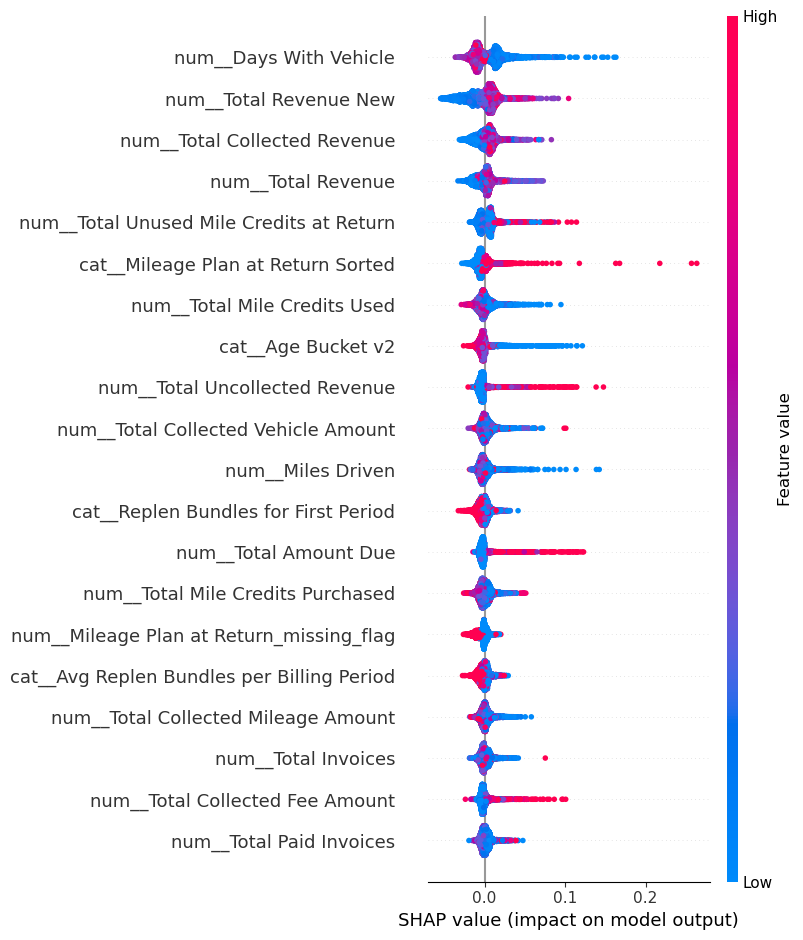

In [235]:
import shap
X_transformed = model_rf.named_steps['preprocess'].transform(X_train)
clf = model_rf.named_steps["rf"]
columns = model_rf.named_steps['preprocess'].get_feature_names_out()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_transformed)
shap.summary_plot(shap_values[:,:,1], X_transformed, feature_names=columns)

# shap

In [ ]:
import pandas as pd
import numpy as np
# data = pd.read_csv('../data/incidents.csv', low_memory=False)
data = pd.read_csv('../data/accidents + drive_score.csv', low_memory=False)

# filter the data with drive score
data = data[data['score_mean'].notnull()]

data['Miles Driven'] = data['Miles Driven'].fillna(0)
data['Insurance Fee at Order'] = data['Insurance Fee at Order'].fillna(0)
data['Total Unused Mile Credits at Return'] = data['Total Unused Mile Credits at Return'].fillna(0)


## --------------- feature engineering ---------------------
# lable the missing data
missing_ratio = data.isnull().mean()
cols_missing_value = missing_ratio[missing_ratio>0].index
df_missing_flag = pd.DataFrame()
for col in cols_missing_value:
    df_missing_flag[col+'_missing_flag'] = data[col].isna().astype(int)
data = pd.concat([data, df_missing_flag], axis=1)

## new features
data['Repo Process Started Date'] = data['Repo Process Started Date'].map(lambda x: 0 if pd.isna(x) else 1)

# # days with car when incident happend
# data['Actual Pickup Date (ET)'] = pd.to_datetime(data['Actual Pickup Date (ET)'])
# data['first_multiparty'] = pd.to_datetime(data['first_multiparty'])
# data['first_multiparty'].fillna(pd.to_datetime("today"), inplace=True)
# data['first_singleparty'] = pd.to_datetime(data['first_singleparty'])
# data['first_singleparty'].fillna(pd.to_datetime("today"), inplace=True)
# days_diff_mp = data['first_multiparty'] - data['Actual Pickup Date (ET)']
# days_diff_sp = data['first_singleparty'] - data['Actual Pickup Date (ET)']
# data['days_in_car_when_MP'] = days_diff_mp.dt.days
# data['days_in_car_when_SP'] = days_diff_sp.dt.days
# data = data[(data['days_in_car_when_MP']>0) & (data['days_in_car_when_SP']>0)] # remove columns if the days with car is negative

columns_to_drop = ['Single Party Incidents', 'Multi Party Incidents', 'early_selfchurn_customer_no_accdient', 
                          'seasoning_3month_SinglePartyIncident', 'seasoning_3month_MultiPartyIncident',
                          'Legacy Order Id', 'Most Recent Vehicle Id', 'Order ID', 'Subscriber ID',
                          'Actual Pickup Date (ET)', 'Returned Date (ET)', 'Cancellation Date (ET)', 'Creation Date (ET)', 'Scheduled Pickup Date (ET)',
                          'Repo Process Started Date',
                          'first_singleparty', 'first_multiparty', 
                          'Single Party Incidents_missing_flag', 'Multi Party Incidents_missing_flag',
                          'first_multiparty_missing_flag', 'first_singleparty_missing_flag',
                          'Initial Vehicle ID', 'days_in_car_when_MP', 'days_in_car_when_SP', 'days_in_car_when_MP_missing_flag', 'days_in_car_when_SP_missing_flag'
                          ]

data = data.drop(columns=columns_to_drop)

# new features
data['vehicle_request_fulfillment'] = (data['Initial Vehicle Make Model'] == data['Requested Vehicle Make Model']).astype(int)


# generat mappings
# vehicle_pop_rank = pd.read_csv('../data/Popular vehicle.csv')
# # vehicle_make_mapping = vehicle_pop_rank[['Popularity Rank', 'Requested Vehicle Make']].set_index('Popularity Rank').to_dict() # rank the car by the popularity
# vehicle_make_mapping = vehicle_pop_rank[['Vehicle_fee_rank', 'Requested Vehicle Make']].set_index('Vehicle_fee_rank').to_dict()
# vehicle_model_pop_rank = pd.read_csv('../data/Popular vehicle model.csv')
# # vehicle_model_mapping = vehicle_model_pop_rank[['Rank', 'Requested Vehicle Make Model']].set_index('Rank').to_dict() # rank the car by the popularity
# vehicle_model_mapping = vehicle_model_pop_rank[['Vehicle_fee_rank', 'Requested Vehicle Make Model']].set_index('Vehicle_fee_rank').to_dict()

# mileage_plan_mapping = {'3. 850 miles': 850, '4. 1200 miles': 1200, '500 miles': 500, 'Pay as you go': 0,
#        '425 miles': 425, '1000 miles': 1000, '600 miles': 600, '2000 miles': 2000, '250 miles': 250,
#        'Pre-monthly': 0}
# 
# # miles overdriven
# data['miles_overdriven'] = data['mileage_plan_at_return_sorted'].map(mileage_plan_mapping)
# data['miles_overdriven'].fillna(data['miles_driven'], inplace=True)
# data['miles_overdriven'] = data['miles_driven'] - data['miles_overdriven']


# # map the popularity rank to the vehicle make
# data['Initial Vehicle Make Model rank'] = data['Initial Vehicle Make Model'].map(vehicle_make_mapping)
# data['Requested Vehicle Make Model rank'] = data['Requested Vehicle Make Model'].map(vehicle_model_mapping)

# map some string features
insurance_plan_mapping = {'Essential Insurance': 1, 'Enhanced Insurance':2}
data['Insurance Plan at Order'] = data['Insurance Plan at Order'].map(insurance_plan_mapping)
data['Insurance Plan at Order'] = data['Insurance Plan at Order'].fillna(0)



# # drop the features replaced
# data.drop(columns=['Initial Vehicle Make Model', 'Requested Vehicle Make Model'], inplace=True)

## -------------- numerical and categorical features ----------------
# split the data into numerical and cat data
df_num = data.select_dtypes(include=np.number)
df_cat = data.select_dtypes(include=['object', 'bool'])

## numerical data
# fill missing value
df_num.fillna(df_num.median(), inplace=True)

## cat data
# fill missing value
# df_cat["mileage_plan_at_return_sorted"].fillna(0, inplace=True) # for mileage we fill 0 for nan
df_cat.fillna(df_cat.mode().iloc[0], inplace=True) # fill other cat with most frequent

# # transfer the cat value into num for some feature
# df_num["mileage_plan_at_return_sorted_int"] = df_cat["mileage_plan_at_return_sorted"].map(lambda x: int(x.split('.')[0]))
# df_cat = df_cat.drop(columns=["mileage_plan_at_return_sorted"]) # drop from cat

# encoding
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

df_cat_encode = pd.DataFrame(enc.fit_transform(df_cat), columns=df_cat.columns)
# for col in df_cat.columns:

#     if col == "mileage_plan_at_return_sorted":
#         df_cat[col] = enc.fit_transform(df_cat[[col]])
#     # df_cat[col] = le.fit_transform(df_cat[col])
#     df_cat[col] = enc.fit_transform(df_cat[col])

df = pd.concat([df_num, df_cat_encode], axis=1)
# df.dropna(inplace=True)


# # over sample the rear class
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
target = 'incident_Ind'
# fill na for target
y = df[target].fillna(0)

# target and predictors
X = df.drop(columns=target)
# X, y = sm.fit_resample(X, y)

In [240]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)

# X = X.drop(columns="mileage_plan_at_return_sorted") # drop the columns which are useless

clf.fit(X, y)
feature_important = pd.DataFrame([X.columns, clf.feature_importances_]).T.sort_values(by=1, ascending=False)
feature_important.columns = ["column_name", "feature_impportant"]
feature_important.head(30)

ValueError: Input y contains NaN.

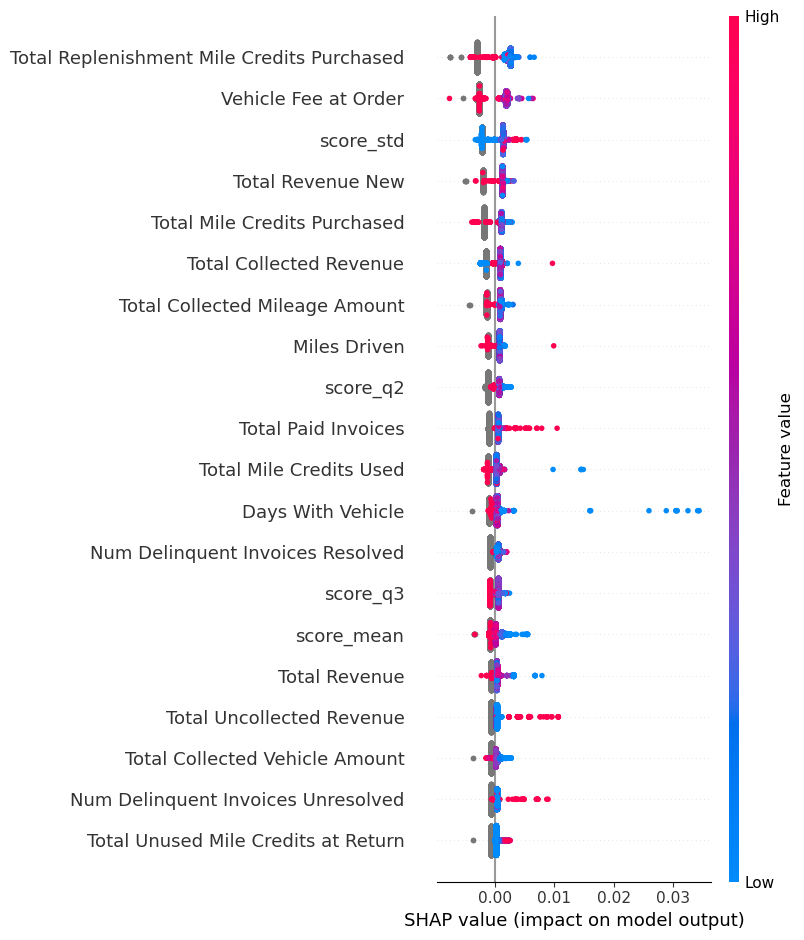

In [238]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values[:,:,1], X)

In [160]:
X.shape

(6094, 85)

In [149]:
from scipy import stats

g1 = df.loc[X['incident_Ind'] == 1, 'score_std'] 
g2 = df.loc[X['incident_Ind'] != 1, 'score_std']

t_statistic, p_value = stats.ttest_ind(g1, g2)

print('t value is:', t_statistic, '. p-val is:', p_value, '.')

KeyError: 'incident_Ind'

In [ ]:
import xgboost
import shap

# train xgboost model on diabetes data:
X, y = X_trian, y_train
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's prediction using SHAP values on the first 1000 training data samples
shap_values = shap.TreeExplainer(bst).shap_values(X)
shap_values.shape